In [ ]:
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os  # We keep this only if you use it elsewhere, but NOT for checking gs:// paths
from scipy.interpolate import CubicSpline

# =============================================================================
# 1. CONFIGURATION & SETUP
# =============================================================================

# Your TIF files mapped to their CENTER YEAR
tif_inventory = {
    1915: "gs://etrace-data/data/koppen_tif_files/koppen_1901_1930.tif",
    1945: "gs://etrace-data/data/koppen_tif_files/koppen_1931_1960.tif",
    1975: "gs://etrace-data/data/koppen_tif_files/koppen_1961_1990.tif",
    2005: "gs://etrace-data/data/koppen_tif_files/koppen_1991_2020.tif",
}

# Load High-Res Shapefile
nuts_shapefile = "gs://etrace-data/data/raw_data/NUTS_RG_01M_2024_3035_LEVL_2.geojson"
print(f"Loading Shapefile: {nuts_shapefile}...")

nuts_gdf = gpd.read_file(nuts_shapefile)
nuts_2 = nuts_gdf[nuts_gdf['LEVL_CODE'] == 2].copy()

# Legend Dictionary (Code -> Name)
koppen_legend = {
    1: 'Af', 2: 'Am', 3: 'Aw', 4: 'BWh', 5: 'BWk', 6: 'BSh', 7: 'BSk',
    8: 'Csa', 9: 'Csb', 10: 'Csc', 11: 'Cwa', 12: 'Cwb', 13: 'Cwc',
    14: 'Cfa', 15: 'Cfb', 16: 'Cfc', 17: 'Dsa', 18: 'Dsb', 19: 'Dsc',
    20: 'Dsd', 21: 'Dwa', 22: 'Dwb', 23: 'Dwc', 24: 'Dwd', 25: 'Dfa',
    26: 'Dfb', 27: 'Dfc', 28: 'Dfd', 29: 'ET', 30: 'EF'
}

# =============================================================================
# 2. EXTRACTION FUNCTION (Process One Map)
# =============================================================================
def extract_climate_profile(gdf, raster_path):
    print(f"Processing raster: {raster_path}")

    # --- FIX START: Open with rasterio first to handle GCS ---
    try:
        with rasterio.open(raster_path) as src:
            # 1. Check CRS and reproject vector if needed
            if gdf.crs != src.crs:
                print(f"Reprojecting vectors to match raster CRS: {src.crs}")
                gdf = gdf.to_crs(src.crs)

            # 2. Read the raster data into memory
            # This avoids zonal_stats failing on the "gs://" path string
            array = src.read(1)
            affine = src.transform
            nodata = src.nodata

            # 3. Run Zonal Stats on the array
            stats = zonal_stats(
                gdf,
                array,
                affine=affine,
                categorical=True,
                nodata=nodata if nodata is not None else 0,
                all_touched=False
            )
    except Exception as e:
        print(f"❌ FAILED to process {raster_path}. Error: {e}")
        return None
    # --- FIX END ---

    # Normalize
    df = pd.DataFrame(stats).fillna(0)
    df['total'] = df.sum(axis=1)

    result_df = pd.DataFrame(index=df.index)
    result_df['NUTS_ID'] = gdf['NUTS_ID'].values

    for col in df.columns:
        # Check if column is a valid Koppen code
        if col != 'total' and (isinstance(col, (int, float)) or (isinstance(col, str) and col.isdigit())):
            code = int(col)
            if code in koppen_legend:
                col_name = f'pct_{koppen_legend[code]}'
                result_df[col_name] = df[col] / df['total']

    return result_df.fillna(0)

# =============================================================================
# 3. RUN EXTRACTION FOR ALL PERIODS
# =============================================================================
anchor_data = {}

for year, path in tif_inventory.items():
    df_anchor = extract_climate_profile(nuts_2, path)
    if df_anchor is not None:
        anchor_data[year] = df_anchor.set_index('NUTS_ID')

print("✓ Extraction complete. Starting interpolation...")


Loading Shapefile: gs://etrace-data/data/raw_data/NUTS_RG_01M_2024_3035_LEVL_2.geojson...
Processing raster: gs://etrace-data/data/koppen_tif_files/koppen_1901_1930.tif
Reprojecting vectors to match raster CRS: EPSG:4326
Processing raster: gs://etrace-data/data/koppen_tif_files/koppen_1931_1960.tif
Reprojecting vectors to match raster CRS: EPSG:4326
Processing raster: gs://etrace-data/data/koppen_tif_files/koppen_1961_1990.tif
Reprojecting vectors to match raster CRS: EPSG:4326
Processing raster: gs://etrace-data/data/koppen_tif_files/koppen_1991_2020.tif
Reprojecting vectors to match raster CRS: EPSG:4326
✓ Extraction complete. Starting interpolation...


Smoothing trends for 299 regions using Cubic Spline...
✓ Smooth interpolation complete.


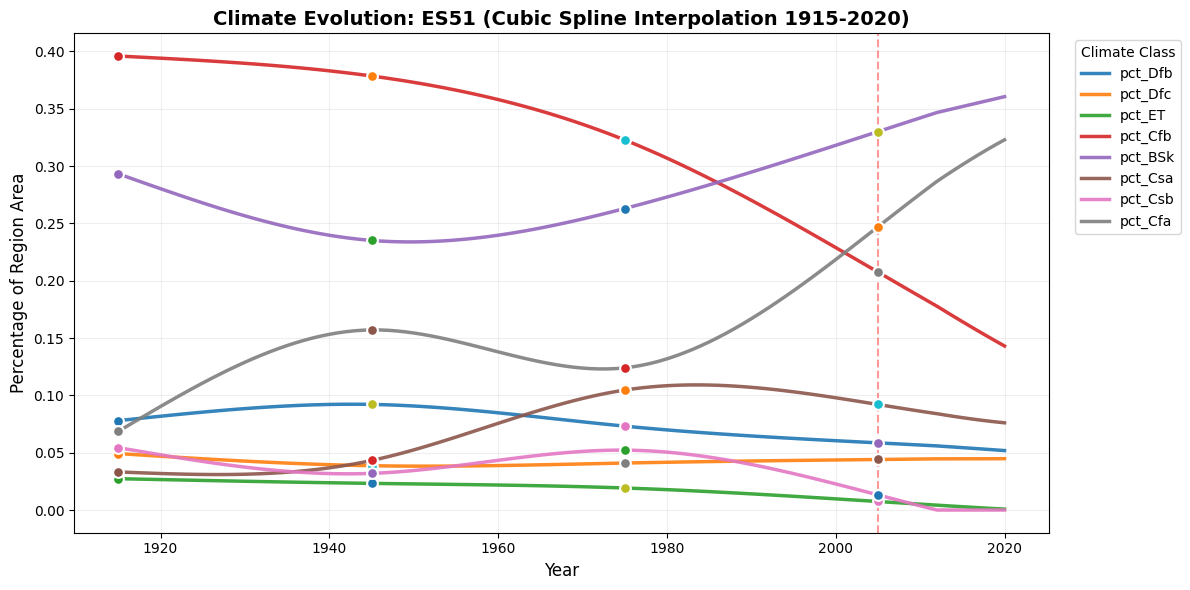

✓ Visualization saved for ES51


In [2]:
# =============================================================================
# 4. UPGRADED: CUBIC SPLINE INTERPOLATION ENGINE (WITH DATA VALIDATION)
# =============================================================================

def create_smooth_trends(anchor_dict, start_year=1915, end_year=2020):
    """
    Uses Cubic Spline to create smooth curves that pass through all anchor points
    and extrapolate naturally beyond the last point.
    """
    # 1. Prepare Data
    panel_list = []
    for y, df in anchor_dict.items():
        df = df.copy()
        df['YEAR'] = y
        panel_list.append(df.reset_index())

    df_anchors = pd.concat(panel_list)

    # CRITICAL FIX: Replace any NaN/inf with 0
    df_anchors = df_anchors.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Get list of all unique regions and columns
    regions = df_anchors['NUTS_ID'].unique()
    climate_cols = [c for c in df_anchors.columns if c.startswith('pct_')]

    # 2. Interpolate Region by Region
    interpolated_frames = []

    print(f"Smoothing trends for {len(regions)} regions using Cubic Spline...")

    skipped_regions = []

    for region in regions:
        # Extract region data sorted by time
        region_data = df_anchors[df_anchors['NUTS_ID'] == region].sort_values('YEAR')

        # SAFETY CHECK: Ensure we have at least 2 time points
        if len(region_data) < 2:
            skipped_regions.append(region)
            continue

        # We need arrays for interpolation
        x_known = region_data['YEAR'].values

        # Create a DataFrame for the target range (1915-2020)
        x_target = np.arange(start_year, end_year + 1)
        df_region_smooth = pd.DataFrame({'YEAR': x_target, 'NUTS_ID': region})

        for col in climate_cols:
            y_known = region_data[col].values

            # ADDITIONAL VALIDATION: Check if all values are valid
            if not np.all(np.isfinite(y_known)):
                # Skip this column for this region if data is corrupt
                df_region_smooth[col] = 0.0
                continue

            try:
                # FIT SPLINE
                cs = CubicSpline(x_known, y_known, bc_type='natural', extrapolate=True)

                # PREDICT
                y_smooth = cs(x_target)

                # Clip values to valid range [0, 1]
                y_smooth = np.clip(y_smooth, 0.0, 1.0)

                df_region_smooth[col] = y_smooth

            except Exception as e:
                # If spline fitting fails for any reason, fallback to 0
                print(f"⚠ Spline failed for {region} - {col}: {e}")
                df_region_smooth[col] = 0.0

        interpolated_frames.append(df_region_smooth)

    if skipped_regions:
        print(f"⚠ Skipped {len(skipped_regions)} regions with insufficient data.")

    # 3. Combine
    final_ts = pd.concat(interpolated_frames)

    # 4. Re-Normalize (Splines might make sum != 1.0 slightly)
    final_ts['total'] = final_ts[climate_cols].sum(axis=1)

    # Avoid division by zero
    final_ts['total'] = final_ts['total'].replace(0, 1)

    for col in climate_cols:
        final_ts[col] = final_ts[col] / final_ts['total']

    return final_ts.drop(columns=['total'])

# =============================================================================
# EXECUTE NEW INTERPOLATION
# =============================================================================

final_ts_smooth = create_smooth_trends(anchor_data, start_year=1915, end_year=2020)
final_ts_smooth.to_csv("NUTS2_Climate_History_Smooth.csv", index=False)
print("✓ Smooth interpolation complete.")

# =============================================================================
# 5. VISUALIZATION (UPDATED)
# =============================================================================
region_id = "ES51" # Cataluña
region_ts = final_ts_smooth[final_ts_smooth['NUTS_ID'] == region_id].set_index('YEAR')

# Filter for relevant climates
pct_columns = [c for c in region_ts.columns if c.startswith('pct_')]
subset_ts = region_ts[pct_columns]
relevant_cols = subset_ts.columns[subset_ts.max() > 0.01]

plt.figure(figsize=(12, 6))

# Plot the Smooth Lines
for col in relevant_cols:
    plt.plot(region_ts.index, region_ts[col], label=col, linewidth=2.5, alpha=0.9)

# Plot the Anchor Dots (The Real Data Points)
for anchor_year in sorted(anchor_data.keys()):
    if anchor_year in region_ts.index:
        for col in relevant_cols:
            plt.scatter(anchor_year, region_ts.loc[anchor_year, col], s=60, zorder=5,
                       edgecolors='white', linewidths=1.5)

plt.title(f'Climate Evolution: {region_id} (Cubic Spline Interpolation 1915-2020)', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Region Area', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(title='Climate Class', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, alpha=0.2)

# Vertical line marking last real data point
plt.axvline(x=2005, color='red', linestyle='--', alpha=0.4, linewidth=1.5, label='Last Anchor (2005)')

plt.tight_layout()
# plt.savefig(f"Climate_Trend_Smooth_{region_id}.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved for {region_id}")
